In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from google.colab import files
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re

In [3]:
def load_sample_data():
    with open('/content/ufc_fighters_stats_and_records.json', 'r') as f:
        return json.load(f)

data = load_sample_data()

In [4]:
# Function to clean and convert string values to numeric
def clean_numeric(value):
    if isinstance(value, str):
        # Remove % and convert to float
        if "%" in value and "(" not in value:  # Check if parentheses are present
            return float(value.replace("%", "")) / 100
        # Extract numbers from strings like "0 (0%)" or "53 (100)"
        match = re.search(r'(\d+)', value)
        if match:
            return float(match.group(1))
        # Try direct conversion
        try:
            return float(value)
        except:
            return None
    return value

In [5]:
# Function to parse W-L-D record
def parse_record(record_str):
    try:
        if isinstance(record_str, str) and "-" in record_str:
            parts = re.search(r'(\d+)-(\d+)-(\d+)', record_str)
            if parts:
                return {
                    'wins': int(parts.group(1)),
                    'losses': int(parts.group(2)),
                    'draws': int(parts.group(3))
                }
    except:
        pass
    return {'wins': 0, 'losses': 0, 'draws': 0}

In [6]:
# Process data into a flat dataframe
def process_data(data):
    processed_data = []
    for fighter in data:
        fighter_data = {}

        # Extract basic info
        for key, value in fighter.get('about', {}).items():
            fighter_data[f'about_{key}'] = value

        # Extract stats
        for key, value in fighter.get('stats', {}).items():
            fighter_data[f'stats_{key}'] = clean_numeric(value)

        # Extract and parse record
        record = fighter.get('record', {}).get('wld', '0-0-0')
        parsed_record = parse_record(record)
        fighter_data['record_wins'] = parsed_record['wins']
        fighter_data['record_losses'] = parsed_record['losses']
        fighter_data['record_draws'] = parsed_record['draws']
        fighter_data['record_total_fights'] = parsed_record['wins'] + parsed_record['losses'] + parsed_record['draws']

        # Calculate win percentage
        if fighter_data['record_total_fights'] > 0:
            fighter_data['record_win_percentage'] = fighter_data['record_wins'] / fighter_data['record_total_fights']
        else:
            fighter_data['record_win_percentage'] = 0

        processed_data.append(fighter_data)

    return pd.DataFrame(processed_data)

df = process_data(data)

In [7]:
# Data cleaning and type conversion
def clean_dataframe(df):
    # Convert age to numeric
    df['about_Age'] = pd.to_numeric(df['about_Age'], errors='coerce')

    # Ensure numeric columns are properly typed
    numeric_cols = [col for col in df.columns if any(x in col for x in ['stats_', 'record_'])]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

df = clean_dataframe(df)

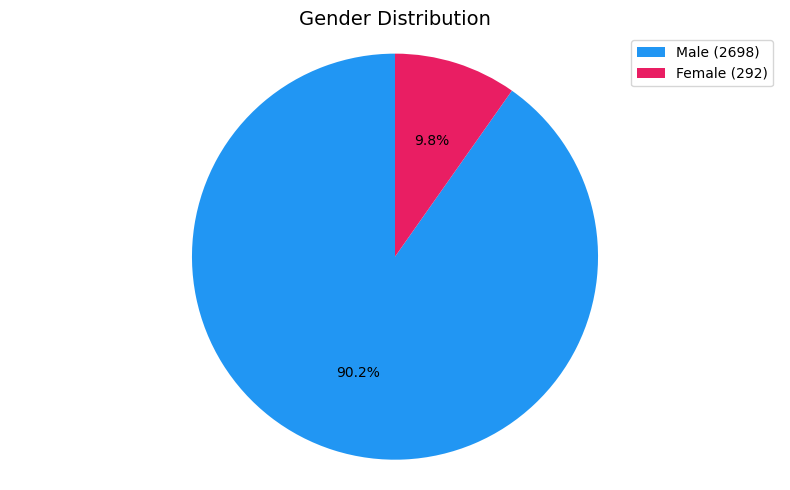

In [79]:
# Gender Distribution Pie Chart
def plot_gender_distribution(df):
    plt.figure(figsize=(8, 5))
    gender_counts = df['about_gender'].value_counts()
    labels = [f'{label} ({count})' for label, count in gender_counts.items()]
    wedges, texts, autotexts = plt.pie(gender_counts, autopct='%1.1f%%', startangle=90, colors=['#2196F3', '#E91E63'])
    plt.title('Gender Distribution', fontsize=14)
    plt.legend(wedges, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_gender_distribution(df)

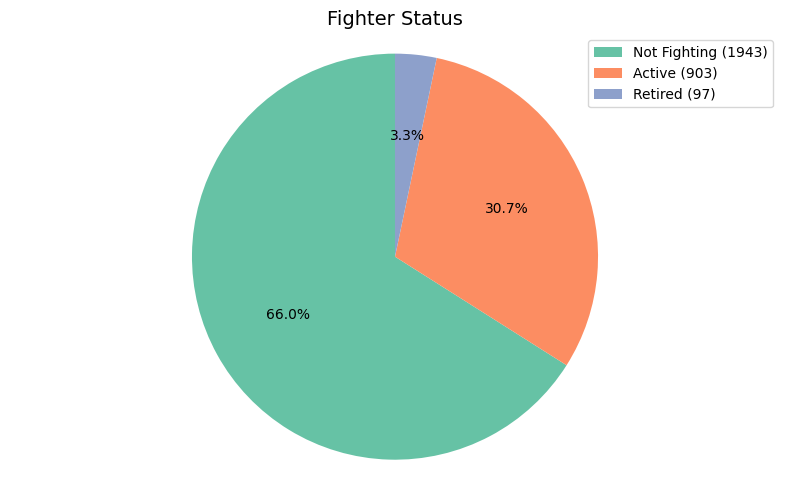

In [75]:
# Fighter Status Pie Chart
def plot_fighter_status(df):
    plt.figure(figsize=(8, 5))
    status_counts = df['about_Status'].value_counts()
    labels = [f'{label} ({count})' for label, count in status_counts.items()]
    wedges, texts, autotexts = plt.pie(status_counts, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
    plt.title('Fighter Status', fontsize=14)
    plt.legend(wedges, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_fighter_status(df)

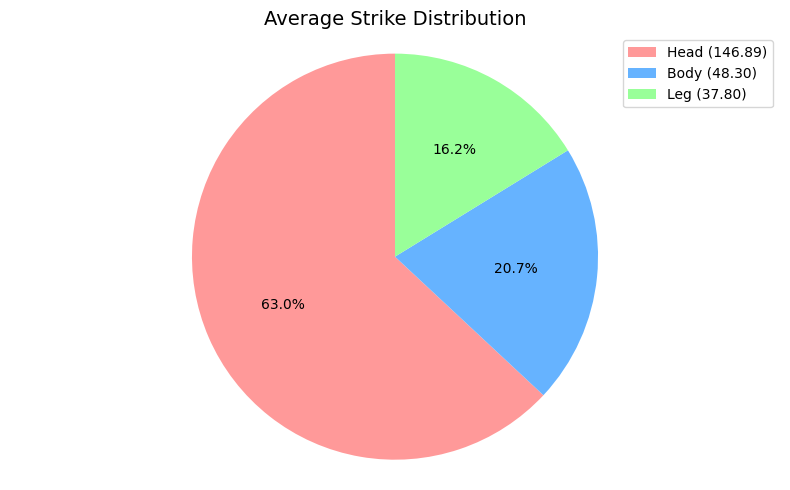

In [89]:
def plot_average_strike_distribution(df):
    plt.figure(figsize=(8, 5))
    strike_counts = {
        'Head': df['stats_Head'].mean(),
        'Body': df['stats_Body'].mean(),
        'Leg': df['stats_Leg'].mean()
    }
    labels = [f'{label} ({value:.2f})' for label, value in strike_counts.items()]
    wedges, texts, autotexts = plt.pie(strike_counts.values(), autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
    plt.title('Average Strike Distribution', fontsize=14)
    plt.legend(wedges, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_average_strike_distribution(df)

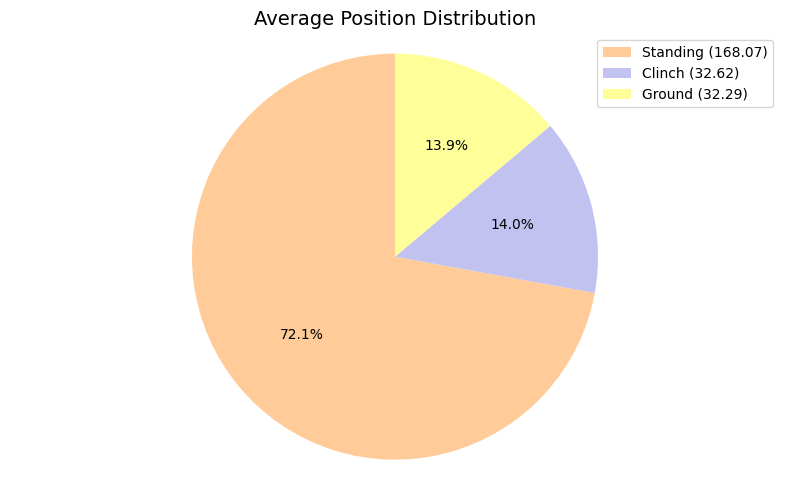

In [90]:
def plot_average_position_distribution(df):
    plt.figure(figsize=(8, 5))
    position_counts = {
        'Standing': df['stats_Standing'].mean(),
        'Clinch': df['stats_Clinch'].mean(),
        'Ground': df['stats_Ground'].mean()
    }
    labels = [f'{label} ({value:.2f})' for label, value in position_counts.items()]
    wedges, texts, autotexts = plt.pie(position_counts.values(), autopct='%1.1f%%', startangle=90, colors=['#ffcc99', '#c2c2f0', '#ffff99'])
    plt.title('Average Position Distribution', fontsize=14)
    plt.legend(wedges, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_average_position_distribution(df)

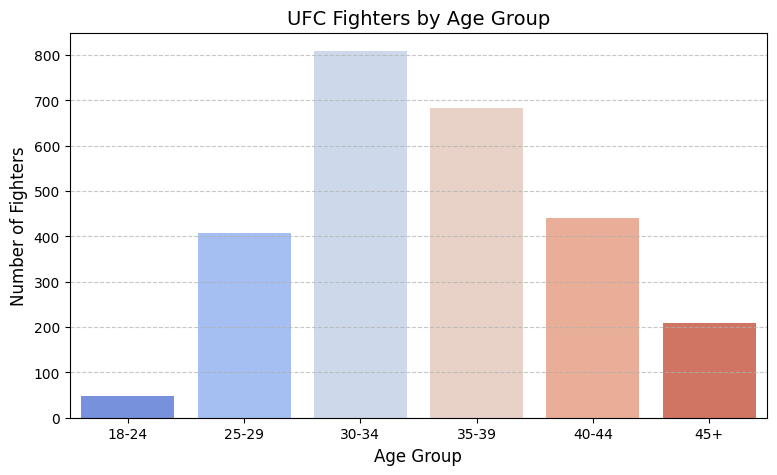

In [97]:
def plot_age_barchart(df):
    plt.figure(figsize=(9, 5))
    age_bins = [18, 25, 30, 35, 40, 45, 50]
    age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45+']
    df['age_group'] = pd.cut(df['about_Age'], bins=age_bins, labels=age_labels, right=False)
    age_counts = df['age_group'].value_counts().sort_index()

    sns.barplot(x=age_counts.index, y=age_counts.values, hue=age_counts.index, palette='coolwarm', legend=False)
    plt.title('UFC Fighters by Age Group', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Number of Fighters', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_age_barchart(df)

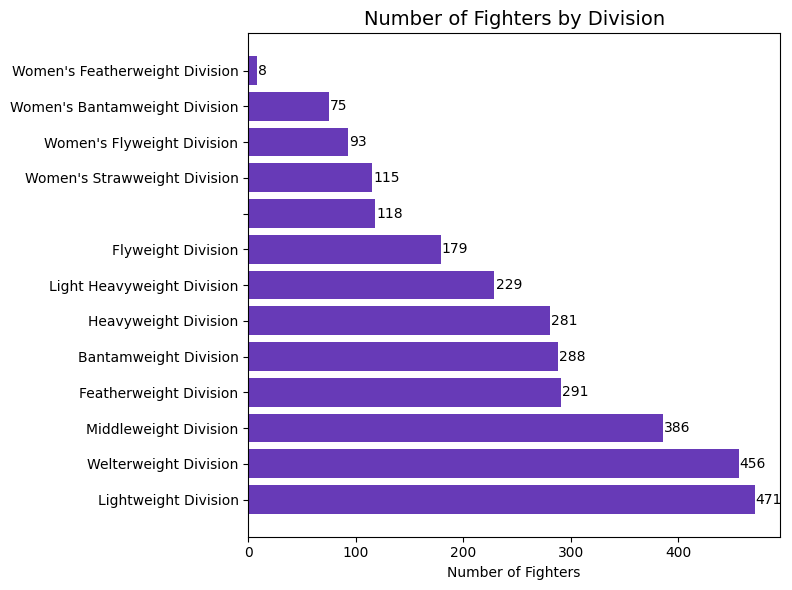

In [100]:
def plot_division_distribution(df):
    # Division distribution
    division_counts = df['about_division'].value_counts().reset_index()
    division_counts.columns = ['Division', 'Count']
    division_counts = division_counts.sort_values('Count', ascending=False)

    # Create horizontal bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(division_counts['Division'], division_counts['Count'], color='#673AB7')
    plt.xlabel('Number of Fighters')
    plt.title('Number of Fighters by Division', fontsize=14)

    # Add value labels
    for i, v in enumerate(division_counts['Count']):
        plt.text(v + 1, i, str(v), va='center')

    plt.tight_layout()
    plt.show()

    return division_counts

division_counts = plot_division_distribution(df)

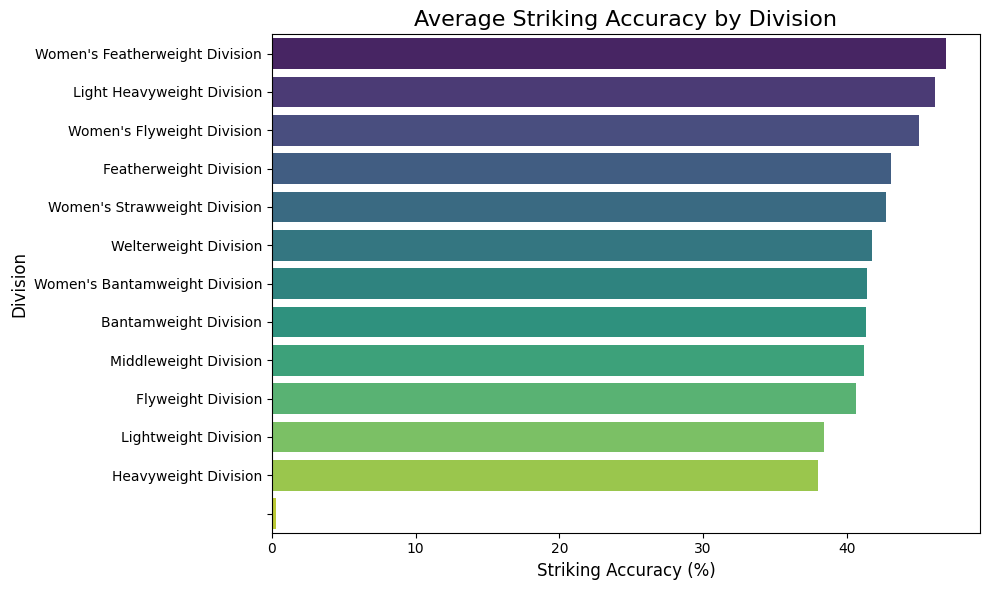

In [119]:
def plot_division_accuracy(df):
    # Check if the required columns are present in the dataframe
    required_columns = {'about_division', 'stats_Sig. Strikes Landed', 'stats_Sig. Strikes Attempted'}
    missing_columns = required_columns - set(df.columns)

    if missing_columns:
        print(f"Missing columns: {', '.join(missing_columns)}")
        return  # Exit if required columns are missing

    # Calculate striking accuracy: (Landed / Attempted) * 100
    df['striking_accuracy'] = (
        df['stats_Sig. Strikes Landed'] / df['stats_Sig. Strikes Attempted']
    ) * 100
    df['striking_accuracy'] = df['striking_accuracy'].fillna(0)  # Handle NaN values as 0

    # Calculate average striking accuracy per division
    division_accuracy = (
        df.groupby('about_division')['striking_accuracy']
        .mean()
        .sort_values(ascending=False)
    )

    # Create bar plot with smaller size and fixed warning
    plt.figure(figsize=(10, 6))  # Adjust size smaller
    sns.barplot(x=division_accuracy.values, y=division_accuracy.index, hue=division_accuracy.index, palette="viridis", legend=False)

    # Labels and title
    plt.title('Average Striking Accuracy by Division', fontsize=16)
    plt.xlabel('Striking Accuracy (%)', fontsize=12)
    plt.ylabel('Division', fontsize=12)

    plt.tight_layout()
    plt.show()

    return division_accuracy

division_accuracy = plot_division_accuracy(df)

<Figure size 1600x1200 with 0 Axes>

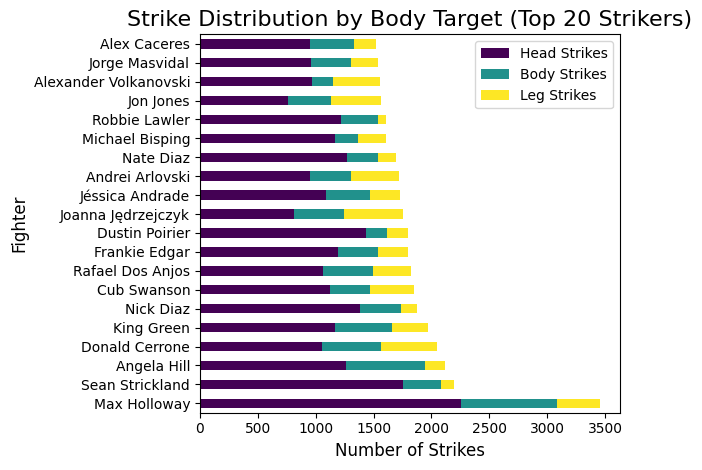

In [120]:
def plot_strike_distribution(df):
    # Ensure required columns exist
    if not {'stats_Head', 'stats_Body', 'stats_Leg', 'about_name'}.issubset(df.columns):
        print("Required columns are missing.")
        return

    # Calculate total strikes
    df['total_strikes'] = df['stats_Head'].fillna(0) + df['stats_Body'].fillna(0) + df['stats_Leg'].fillna(0)

    # Select top 20 strikers
    top_strikers = df.sort_values('total_strikes', ascending=False).head(20)

    # Create a dataframe for strike distribution
    strike_data = [
        {
            'Fighter': row['about_name'],
            'Head Strikes': row['stats_Head'] if pd.notna(row['stats_Head']) else 0,
            'Body Strikes': row['stats_Body'] if pd.notna(row['stats_Body']) else 0,
            'Leg Strikes': row['stats_Leg'] if pd.notna(row['stats_Leg']) else 0
        }
        for _, row in top_strikers.iterrows()
    ]

    strike_df = pd.DataFrame(strike_data).set_index('Fighter')

    # Plot stacked bar chart
    plt.figure(figsize=(16, 12))
    strike_df.plot(kind='barh', stacked=True, colormap='viridis')

    # Labels and title
    plt.title('Strike Distribution by Body Target (Top 20 Strikers)', fontsize=16)
    plt.xlabel('Number of Strikes', fontsize=12)
    plt.ylabel('Fighter', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_strike_distribution(df)

In [124]:
# Interactive Division Stats Dashboard
def create_division_dashboard(df):
    # Group by division and calculate averages
    division_stats = df.groupby('about_division').agg({
        'stats_Sig. Str. Landed Per Min': 'mean',
        'stats_Sig. Str. Absorbed Per Min': 'mean',
        'stats_Takedown avg Per 15 Min': 'mean',
        'stats_Submission avg Per 15 Min': 'mean',
        'record_win_percentage': 'mean',
        'about_Age': 'mean'
    }).reset_index()

    # Create a subplot with 2 rows, 3 columns
    fig = make_subplots(rows=2, cols=3,
                       subplot_titles=('Strikes Landed/Min', 'Strikes Absorbed/Min',
                                      'Takedowns/15Min', 'Submissions/15Min',
                                      'Win Percentage', 'Average Age'))

    # Add traces for each metric
    fig.add_trace(
        go.Bar(x=division_stats['about_division'], y=division_stats['stats_Sig. Str. Landed Per Min'],
              marker_color='blue'),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x=division_stats['about_division'], y=division_stats['stats_Sig. Str. Absorbed Per Min'],
              marker_color='red'),
        row=1, col=2
    )

    fig.add_trace(
        go.Bar(x=division_stats['about_division'], y=division_stats['stats_Takedown avg Per 15 Min'],
              marker_color='green'),
        row=1, col=3
    )

    fig.add_trace(
        go.Bar(x=division_stats['about_division'], y=division_stats['stats_Submission avg Per 15 Min'],
              marker_color='purple'),
        row=2, col=1
    )

    fig.add_trace(
        go.Bar(x=division_stats['about_division'], y=division_stats['record_win_percentage'],
              marker_color='orange'),
        row=2, col=2
    )

    fig.add_trace(
        go.Bar(x=division_stats['about_division'], y=division_stats['about_Age'],
              marker_color='brown'),
        row=2, col=3
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        title_text="UFC Division Statistics Dashboard",
        showlegend=False
    )

    # Update x-axis layout
    fig.update_xaxes(tickangle=45)

    fig.show()

create_division_dashboard(df)

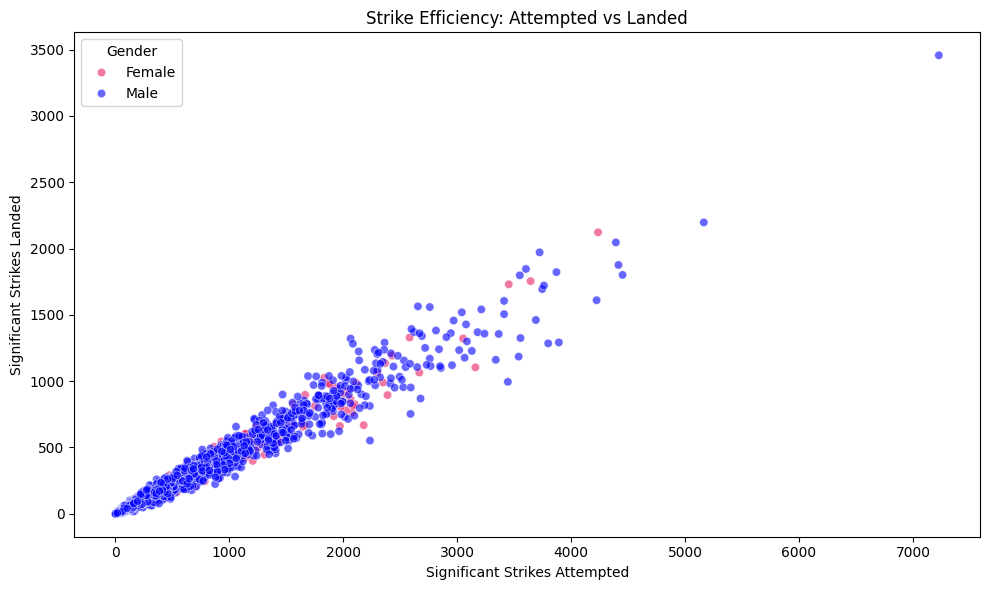

In [129]:
# Strike Efficiency (Landed vs Attempted)
def plot_strike_efficiency(df):
    # Check if required columns are present in the dataframe
    required_columns = {'stats_Sig. Strikes Landed', 'stats_Sig. Strikes Attempted', 'about_gender'}
    missing_columns = required_columns - set(df.columns)

    if missing_columns:
        print(f"Missing columns: {', '.join(missing_columns)}")
        return  # Exit if required columns are missing

    # Define custom color palette
    gender_palette = {
        'Female': '#E91E63',
        'Male': 'blue',  # Assuming 'med' refers to male, adjust if needed
        'Other': 'gray'  # Optional: handle any other genders if applicable
    }

    # Create scatter plot with custom colors
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='stats_Sig. Strikes Attempted',
        y='stats_Sig. Strikes Landed',
        data=df,
        hue='about_gender',
        palette=gender_palette,
        alpha=0.6
    )

    # Labels and title
    plt.title('Strike Efficiency: Attempted vs Landed')
    plt.xlabel('Significant Strikes Attempted')
    plt.ylabel('Significant Strikes Landed')
    plt.legend(title='Gender')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_strike_efficiency(df)

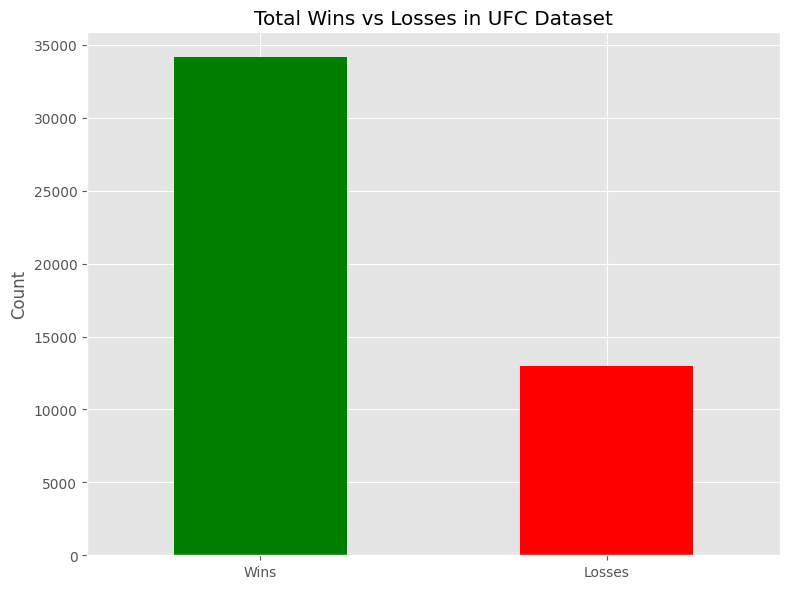

In [131]:
def plot_win_loss_distribution(df):
    # Check if 'Wins' and 'Losses' columns exist in the dataframe
    if 'Wins' not in df.columns or 'Losses' not in df.columns:
        print("Missing 'Wins' or 'Losses' column in the dataframe.")
        return

    # Calculate total wins and losses
    wl_counts = df[['Wins', 'Losses']].sum()

    # Create bar plot
    plt.figure(figsize=(8, 6))
    wl_counts.plot(kind='bar', color=['green', 'red'])

    # Labels and title
    plt.title('Total Wins vs Losses in UFC Dataset')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_win_loss_distribution(df)

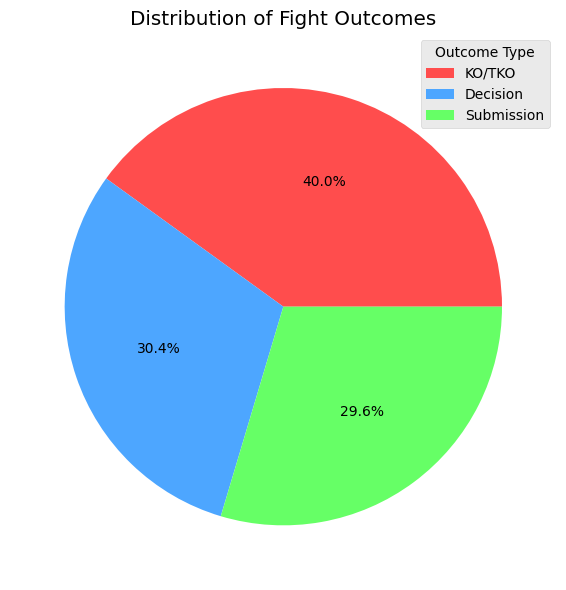

In [143]:
def plot_fight_outcome_distribution(df):
    # Required columns for fight outcomes
    outcome_cols = ['stats.KO/TKO', 'stats.DEC', 'stats.SUB']

    # Check if all required columns exist
    if not all(col in df.columns for col in outcome_cols):
        print("Missing required columns in the dataframe.")
        return

    # Extract numeric values and calculate sum for each outcome type
    outcome_data = df[outcome_cols].apply(lambda x: x.str.extract(r'(\d+)')[0].astype(float).sum())

    # Define colors and labels
    colors = ['#ff4d4d', '#4da6ff', '#66ff66']
    labels = ['KO/TKO', 'Decision', 'Submission']

    # Create pie chart
    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(outcome_data, autopct='%1.1f%%', colors=colors)

    # Add legend
    plt.legend(wedges, labels, title="Outcome Type", loc="best")

    # Labels and title
    plt.title('Distribution of Fight Outcomes')
    plt.ylabel('')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_fight_outcome_distribution(df)